In [89]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import torchvision.transforms.functional as F

import scipy.misc

from pathlib import Path

from PIL import Image
import skimage
from skimage import io
from skimage import transform
import PIL

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import sys
#import elasticdeform
import matplotlib.image as mpimg
import random
from torch.nn import CrossEntropyLoss, Sequential, Linear

from torch.autograd import Variable
import imageio
import cv2
from skimage import exposure

from IPython.display import clear_output
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Preprocess

In [142]:
train_df = pd.read_csv('mnist_train.csv')

In [144]:
targets_numpy = train_df.label.values
features_numpy = train_df.loc[:,train_df.columns != "label"].values/255

In [145]:
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

In [146]:
featuresTrain = t.from_numpy(features_train)
targetsTrain = t.from_numpy(targets_train).type(t.LongTensor)

In [147]:
featuresTest = t.from_numpy(features_test)
targetsTest = t.from_numpy(targets_test).type(t.LongTensor)

In [148]:
train = t.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = t.utils.data.TensorDataset(featuresTest,targetsTest)

In [149]:
train_dataloader = t.utils.data.DataLoader(train, batch_size = 32, shuffle = False)
test_dataloader = t.utils.data.DataLoader(test, batch_size = 32, shuffle = False)

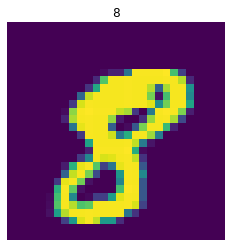

In [150]:
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [151]:
featuresTest.shape

torch.Size([8400, 784])

In [152]:
test_df = pd.read_csv('mnist_test.csv')

In [154]:
test_features_numpy = test_df.loc[:].values/255

In [155]:
features_original_test = t.from_numpy(test_features_numpy)

In [156]:
test_set = t.utils.data.TensorDataset(features_original_test)

In [157]:
testdataloader = t.utils.data.DataLoader(test_set, batch_size = 1)

### Train

In [165]:
dtype=t.FloatTensor

def train(network, epochs, learning_rate, loss=t.nn.NLLLoss(), optim=t.optim.Adam, use_cuda=False):
    train_loss_epochs = []
    test_loss_epochs = []
    
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    optimizer = optim(network.parameters(), learning_rate)
    
    for epoch in range(epochs):
        model.train()
        
        current_loss = []
        current_accuracy = []

        for sample in train_dataloader:
            X = sample[0]
            X = X.type(dtype)
            y = sample[1]
                    
            
            if use_cuda:
                X = X.cuda()
                y = y.cuda()
                
                
                
            
            optimizer.zero_grad()
            prediction = network(X)
            loss_batch = loss(prediction, y)
            
            current_loss.append(loss_batch.item())
            current_accuracy.append((prediction.argmax(dim=1) == y).float().mean().item())
            
            loss_batch.backward()
            optimizer.step()

            
            
        
        train_loss_epochs.append(np.mean(current_loss))
        train_accuracy_epochs.append(np.mean(current_accuracy))
        
        
        model.eval()
        
        current_loss = []
        current_accuracy = []
        with t.no_grad():
            for sample in test_dataloader:
                X = sample[0]
                X = X.type(dtype)
                y = sample[1]
                
                if use_cuda:
                    X = X.cuda()
                    y = y.cuda()

                prediction = network(X)
                loss_batch = loss(prediction, y)

                current_loss.append(loss_batch.item())            
                current_accuracy.append((prediction.argmax(dim=1) == y).float().mean().item())
        
        test_loss_epochs.append(np.mean(current_loss))
        test_accuracy_epochs.append(np.mean(current_accuracy))
        
        
        clear_output(True)
        
        sys.stdout.write('\rEpoch {0}... (Train/Test) Loss: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                    epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                    train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
       
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_epochs, label='Train')
        plt.plot(test_loss_epochs, label='Test')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracy_epochs, label='Train accuracy')
        plt.plot(test_accuracy_epochs, label='Test accuracy')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Accuracy', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.show()
       

### Network

In [169]:
class Net1(t.nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv_layers = t.nn.Sequential(t.nn.Conv2d(1, 16, 3, padding=0), t.nn.ReLU(),
                                         t.nn.Conv2d(16, 16, 3, padding=0), t.nn.ReLU(),
                                         t.nn.MaxPool2d(2),
                                         t.nn.Conv2d(16, 32, 3, padding=0), t.nn.ReLU(),
                                         t.nn.Conv2d(32, 32, 3, padding=0), t.nn.ReLU(),
                                         t.nn.MaxPool2d(2)
                                        )
        self.linear_layers = t.nn.Sequential(t.nn.Linear(4*4*32, 10), t.nn.LogSoftmax(dim=1))
    def forward(self, x):
        out1 = x.view(x.size(0), 1, 28, 28)
        out2 = self.conv_layers(out1)
        out3 = out2.view(out2.size(0), -1)
        out4 = self.linear_layers(out3)
        
        return out4

In [170]:
class Net2(t.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.linear_layers = t.nn.Sequential(t.nn.Linear(784, 100), t.nn.ReLU(), 
                                             t.nn.Linear(100, 100), t.nn.ReLU(),
                                             t.nn.Linear(100, 10)
                                              )
        self.linear_layers2 = t.nn.Sequential(t.nn.Linear(784, 10))
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        out = self.linear_layers(x)
        
        return out

In [171]:
use_cuda = False

In [172]:
model = Net1()


In [46]:
model = Net2()

In [173]:
if use_cuda:
    model.cuda()

Epoch 4... (Train/Test) Loss: 0.042/0.059	Accuracy: 0.988/0.981

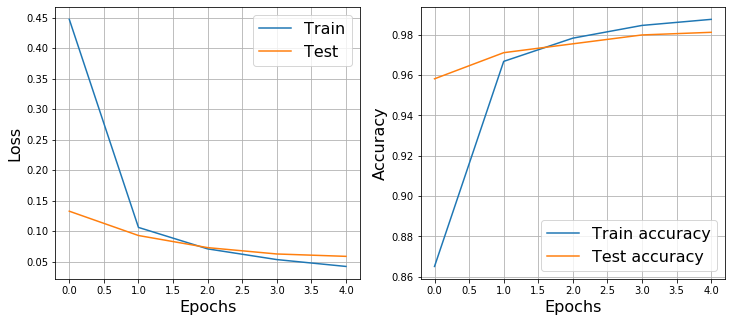

In [174]:
train(model, 5, 0.0001, use_cuda = use_cuda)

### Errors analysis

In [50]:
wrong_X = []
correct_y = []
predicted_y = []

model.eval()
with t.no_grad():
    for sample in test_dataloader:
        X = sample[0]
        X = X.type(dtype)
        y = sample[1]

        if use_cuda:
            X = X.cuda()
            y = y.cuda()

        prediction = model(X).cpu().detach().numpy()
        prediction = np.exp(prediction)
        prediction /= prediction.sum(1, keepdims=True)

        for i in range(len(prediction)):
            if np.argmax(prediction[i]) != y[i]:
                wrong_X.append(X[i])
                correct_y.append(y[i])
                predicted_y.append(np.argmax(prediction[i]))

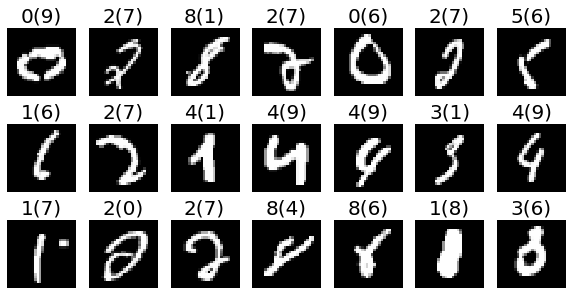

In [180]:
plt.figure(figsize=(10, 5))
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[i].cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[i], predicted_y[i]), fontsize=20)
    plt.axis('off')

### Test evaluation

In [175]:
submission_df = pd.DataFrame(columns = ['ImageId', 'Label'])

In [176]:
model = model.eval()

In [177]:
with t.no_grad():
    for ind,sample in enumerate(testdataloader):
        X = sample[0]
        X = X.type(dtype)

        if use_cuda:
            X = X.cuda()

        prediction = model(X)

        label = np.argmax(prediction[0].cpu().detach().numpy()).astype(int)

        submission_df.loc[ind] = [ind+1, label]

In [178]:
submission_df.head(5)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [179]:
submission_df.to_csv('mnist_predictions.csv', index=False)